In [ ]:
import sys
#sys.path.append(r' working directory') # This path must contain this file, mask_funcs.py and utils.py

In [2]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import torch
import cv2
from natsort import natsorted
import mask_funcs
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
class MissingCell:
    def __init__(self, mask):
        self.mask = mask
        self.missing_count = 0

class Tracker:
    def __init__(self, name, mask_directory, image_directory, tracked_directory, view_tracks_directory, frame_memory = 3, overlap_threshold = 0.4):
        self.name = name
        self.mask_ims = natsorted([mask for mask in (mask_directory).iterdir()])
        self.images = natsorted([image for image in (image_directory).iterdir()])
        self.tracked_directory = tracked_directory
        self.view_tracks_directory = view_tracks_directory
        self.old_frame = torch.tensor(utils.read_tiff(self.mask_ims[0]).astype(np.int16)).to(device)
        self.new_frame = torch.tensor(utils.read_tiff(self.mask_ims[1]).astype(np.int16)).to(device)
        self.max_index = torch.max(self.old_frame)
        self.missing_cells = {} # key is cell index, value is instance of MissingCell class
        self.frame_memory = frame_memory
        self.overlap_threshold = overlap_threshold

    def add_missing_masks(self):
        for missing_index in self.missing_cells.keys():
            if missing_index not in self.old_frame:
                self.old_frame = torch.where(self.missing_cells[missing_index].mask.bool(), missing_index, self.old_frame)

    def update_new_frame(self):
        updated_new_frame = torch.zeros((1200, 1200)).to(device)
        self.add_missing_masks()
        for new_mask, mask_index in mask_funcs.SplitMask(self.new_frame):
            intersection = torch.logical_and(new_mask, self.old_frame != 0)
            indexes, counts = torch.unique(self.old_frame[intersection], return_counts=True)
            if len(indexes) > 0 and torch.max(counts) > self.overlap_threshold*torch.sum(new_mask):
                new_index = indexes[torch.argmax(counts)]
                self.old_frame = torch.where(self.old_frame==indexes[torch.argmax(counts)], 0, self.old_frame)
                if new_index in self.missing_cells:
                    del self.missing_cells[new_index]
            else:
                new_index = self.max_index + 1
                self.max_index = new_index
            updated_new_frame += new_mask*int(new_index)

        for missing_index in list(self.missing_cells.keys()):
            self.missing_cells[missing_index].missing_count += 1
            if self.missing_cells[missing_index].missing_count >= self.frame_memory:
                if missing_index in self.old_frame:
                    self.old_frame = torch.where(self.old_frame==missing_index, 0, self.old_frame)
                del self.missing_cells[missing_index]

        for missing_mask, missing_index in mask_funcs.SplitMask(self.old_frame):
            if missing_index not in self.missing_cells.keys():
                self.missing_cells[missing_index] = MissingCell(missing_mask)
        self.new_frame = updated_new_frame

    def track(self):
        print('\n--------------------\nTRACKING - ', self.name, '\n--------------------')

        utils.save_tiff(self.old_frame.to(dtype=torch.int16).cpu().numpy().astype(np.uint16),
                        self.tracked_directory / ("{0:04}".format(0) + '.tif'))

        for i in range(1, len(self.mask_ims)):
            sys.stdout.write(
                f'\rAdding frame {i+1} / {len(self.mask_ims)}')
            sys.stdout.flush()

            self.new_frame = torch.tensor(utils.read_tiff(self.mask_ims[i]).astype(np.int16)).to(device)
            self.update_new_frame()
            self.old_frame = self.new_frame
            utils.save_tiff(self.old_frame.to(dtype=torch.int16).cpu().numpy().astype(np.uint16), self.tracked_directory / ("{0:04}".format(i) + '.tif'))

    def show_tracks(self, num_frames=None):
        print('\n--------------------\nSHOWING TRACKS - ', self.name, '\n--------------------')
        self.tracked_masks = sorted([mask for mask in (self.tracked_directory).iterdir()])
        colour_dict = {}
        if num_frames is None:
            num_frames = len(self.tracked_masks)
        for i in range(num_frames):
            sys.stdout.write(
                f'\rAdding frame {i + 1} / {num_frames}')
            sys.stdout.flush()
            temp = utils.read_tiff(self.images[i]).astype(np.int16)
            mask = torch.tensor(utils.read_tiff(self.tracked_masks[i]).astype(np.uint8)).to(device)
            #im_rgb = torch.tensor(utils.read_tiff(self.images[i]).astype(np.int16)).to(device)
            im_rgb = torch.tensor(temp).to(device)
            print(temp)
            print(im_rgb.shape)
            # im_rgb = im_rgb.permute(2, 0, 1)
            # 
            # for j in range(torch.max(mask)):
            #     if j+1 in mask:
            #         if j+1 not in colour_dict.keys():
            #             colour_dict[j+1] = torch.tensor(np.random.uniform(0, 2**(8)-1, size=3)).to(device)
            #         single_mask = torch.where(mask==j+1, 1, 0)
            #         outline = mask_funcs.mask_outline(single_mask, 3)
            #         for c in range(3):
            #             im_rgb[c] = torch.where(outline, colour_dict[j+1][c], im_rgb[c])
            # im_rgb = im_rgb.permute(1, 2, 0)
            utils.save_tiff((im_rgb).cpu().numpy().astype(np.uint8), self.view_tracks_directory / ("{0:04}".format(i) + '.jpg'))



--------------------
TRACKING -  Amoebas 
--------------------
Adding frame 64 / 64
--------------------
SHOWING TRACKS -  Amoebas 
--------------------
Adding frame 1 / 64[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 2 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
torch.Size([1200, 1200])
Adding frame 2 / 64[[3 3 3 ... 3 3 3]
 [3 3 4 ... 4 3 3]
 [3 3 3 ... 4 3 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
torch.Size([1200, 1200])
Adding frame 3 / 64[[3 3 4 ... 3 4 4]
 [3 3 3 ... 3 3 4]
 [3 3 3 ... 3 3 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
torch.Size([1200, 1200])
Adding frame 4 / 64[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
torch.Size([1200, 1200])
Adding frame 5 / 64[[3 4 3 ... 4 4 4]
 [3 3 3 ... 4 4 3]
 [3 3 3 ... 4 4 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
torch.Size([1200, 1200])
Adding frame 6 / 64[[3 4 4

(-0.5, 1199.5, 1199.5, -0.5)

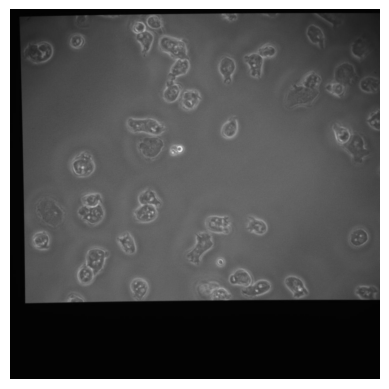

In [27]:
# inputs
mask_path = r'Phase_masks/amoeba'
image_path = r'PHASE'

# output
tracked_path = r'Tracks'
view_tracks_path = r'show tracks'

utils.remake_dir(Path(tracked_path))
utils.remake_dir(Path(view_tracks_path))


my_tracker = Tracker('Amoebas', Path(mask_path), Path(image_path), Path(tracked_path), Path(view_tracks_path))
my_tracker.track()
my_tracker.show_tracks()


img = cv2.imread(os.path.join(view_tracks_path, os.listdir(view_tracks_path)[0]))
plt.imshow(img)
plt.axis("off")